Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# !rm -rf "/content/Skin cancer ISIC The International Skin Imaging Collaboration"

In [ ]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/CNN assignment/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/CNN assignment/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

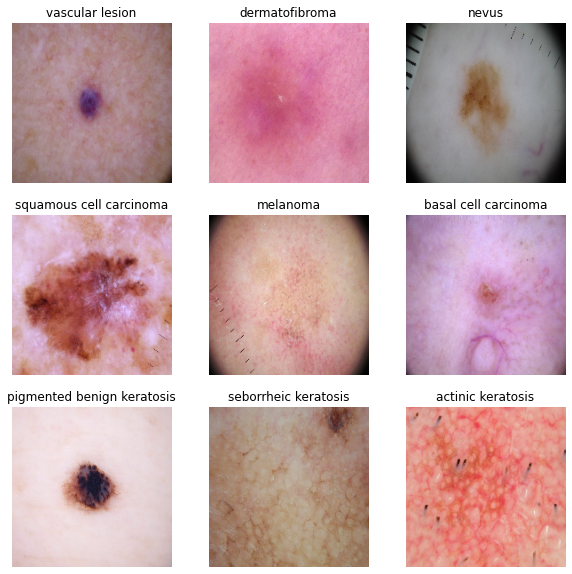

In [ ]:
import matplotlib.pyplot as plt

# ### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in list(train_ds.take(1)):
  j=0
  c = []
  for i in range(32):
    if(class_names[labels[i]] in c):
      continue
    c.append(class_names[labels[i]])
    ax = plt.subplot(3, 3, j + 1)
    j+=1
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

sometime it displays repeated class because of having same images from one class in a batch so keeping the logic and displaying first 9 images from the train data below.

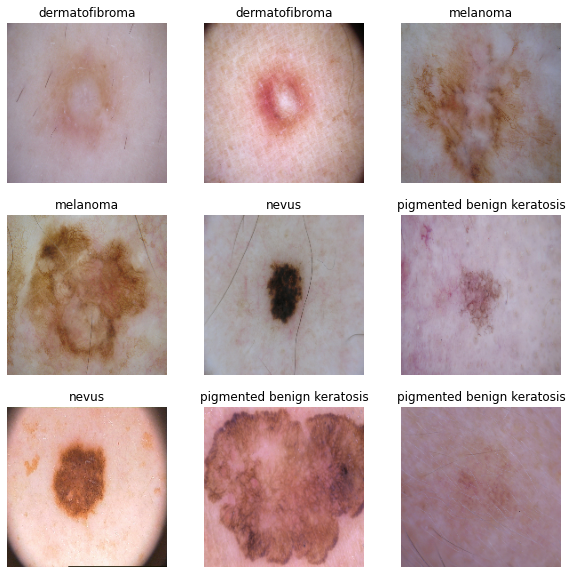

In [ ]:
# import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
c=0
for images, labels in list(train_ds.take(1)):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))




### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
## Your code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adamax',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_30 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_132 (Dropout)        (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 89, 89, 32)        9248      
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 87, 87, 32)      

### Train the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history = model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_ds,
          callbacks=[learning_rate_reduction])

Epoch 1/20
56/56 [==============================] - 17s 88ms/step - loss: 2.1044 - accuracy: 0.2106 - val_loss: 1.8807 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 2s 35ms/step - loss: 1.7906 - accuracy: 0.3562 - val_loss: 1.6396 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 1.6343 - accuracy: 0.4024 - val_loss: 1.5756 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.5991 - accuracy: 0.4079 - val_loss: 1.5472 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.5858 - accuracy: 0.4513 - val_loss: 1.5497 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.5349 - accuracy: 0.4755 - val_loss: 1.5426 - val_accuracy: 0.4832
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.4850 - accuracy: 0.4913 - val_loss: 1.4668 - val_accuracy: 0.4899
Epoch 8/20
5

### Visualizing training results

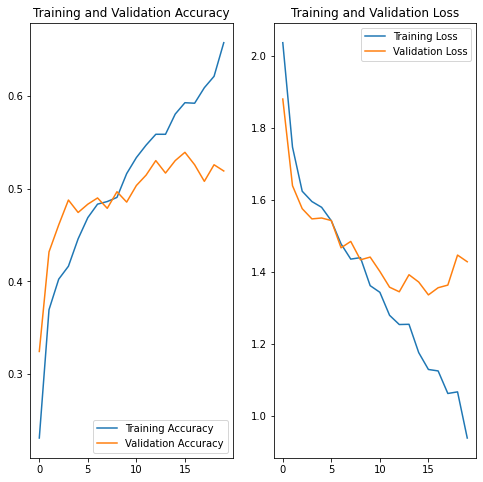

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings
- After analysing the above graph we can clearly see that our model is overfitting.

##### To over-come this we will use data augumentaion technique which is of 2 types
- Make the preprocessing layers part of your model
- Apply the preprocessing layers to your dataset

__We will use the layer strartegy because it will then become part of the model and no need to make changes to dataset and by this we can skip the server side logic while deploying the model.__

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = Sequential([
  # layers.experimental.preprocessing.Rescaling(1, input_shape=(img_height, img_width,3)),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2,fill_mode="reflect"),
  # layers.experimental.preprocessing.RandomTranslation((-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='reflect'),
  # layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='reflect')
])

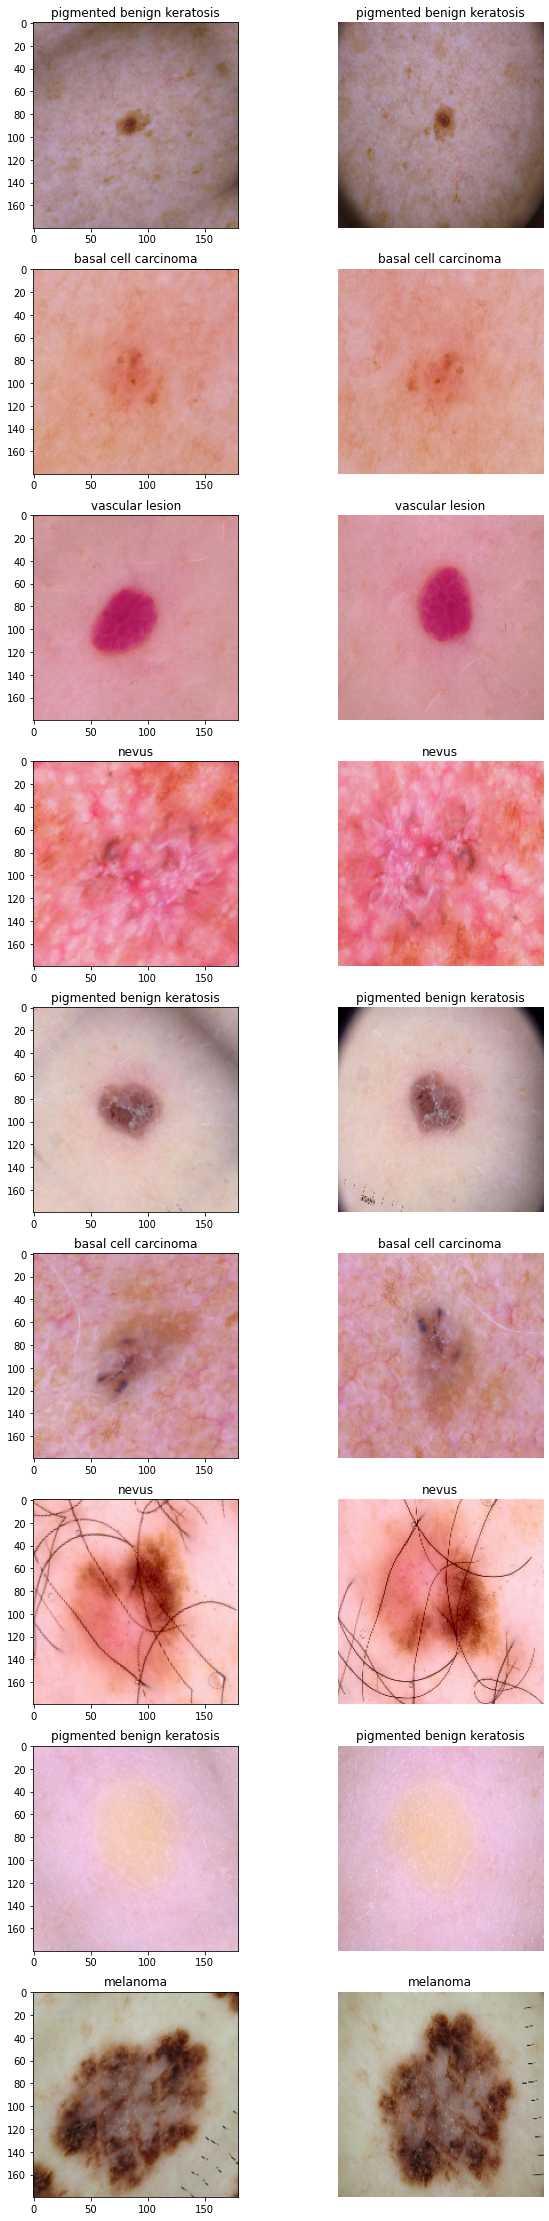

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 40))
c=0
for images, labels in list(train_ds.take(1)):
  augmented_image = data_augmentation(images)
  j=0
  for i in range(9):
    ax = plt.subplot(9, 2, j + 1)
    j+=1
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

    ax = plt.subplot(9, 2, j + 1)
    j+=1
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title(class_names[labels[i]])
    plt.axis("off")

  plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))




### Compiling the model

In [ ]:
## Your code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adamax',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_44 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_47 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_339 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_340 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_341 (Conv2D)          (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_342 (Conv2D)          (None, 87, 87, 64)      

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history = model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_ds,
          callbacks=[learning_rate_reduction])

Epoch 1/20
56/56 [==============================] - 4s 52ms/step - loss: 2.0857 - accuracy: 0.2096 - val_loss: 2.0061 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8946 - accuracy: 0.2803 - val_loss: 1.6922 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.6497 - accuracy: 0.4276 - val_loss: 1.7545 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 3s 50ms/step - loss: 1.5853 - accuracy: 0.4543 - val_loss: 1.5773 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 3s 50ms/step - loss: 1.5560 - accuracy: 0.4400 - val_loss: 1.5171 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4642 - accuracy: 0.4929 - val_loss: 1.4418 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4328 - accuracy: 0.4902 - val_loss: 1.4480 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

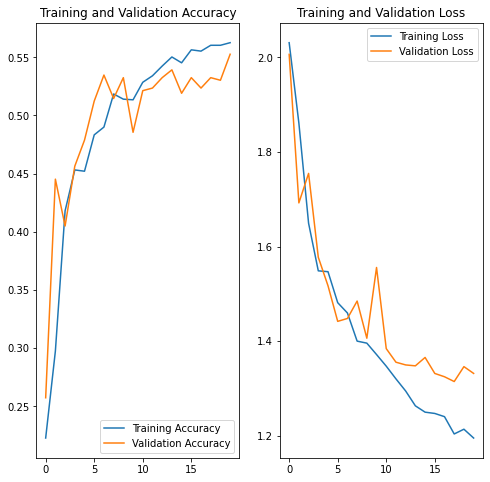

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After doig data augumentation the training and validation accuracy gap has drastically reduced.

Definitley the model has improved as compared to previous one.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

                        class  counts
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


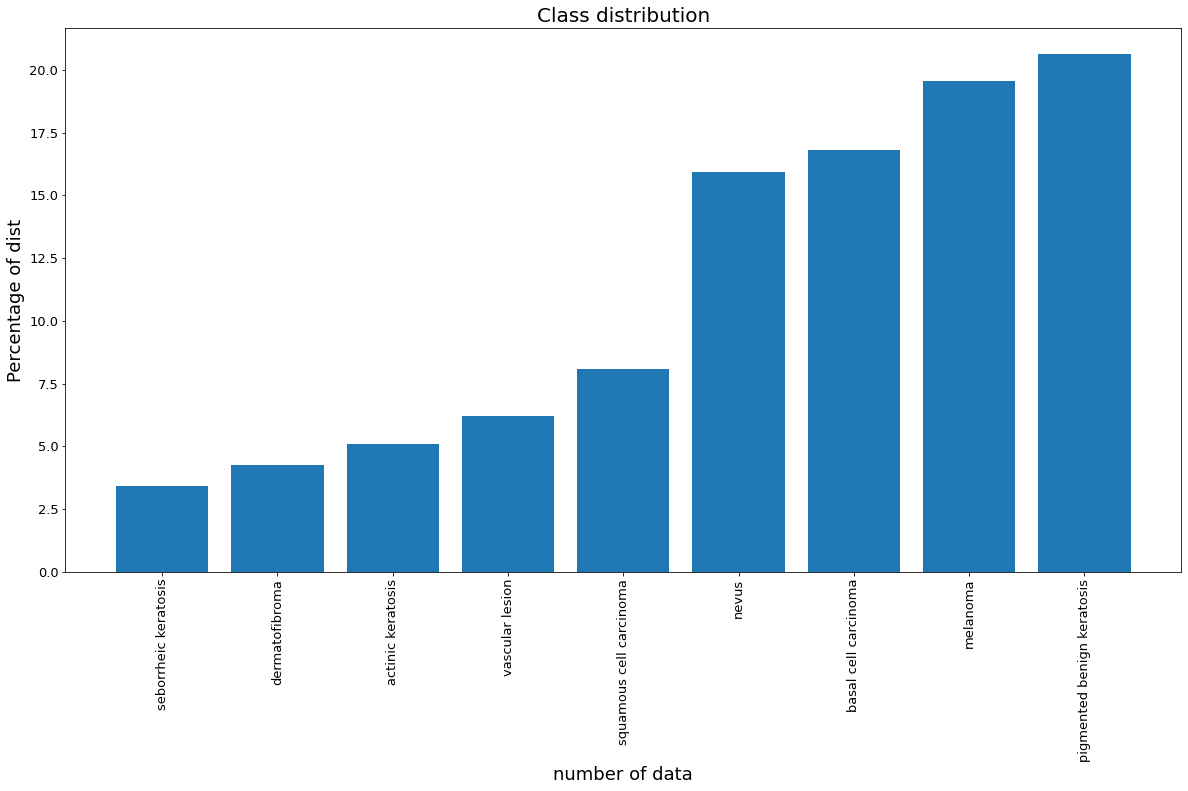

In [ ]:
import glob
df  = []
for i in class_names:
  path_list = [x for x in data_dir_train.glob(i+'/*.jpg')]
  df.append(len(path_list))
df = pd.DataFrame(list(zip(class_names,df)),columns=["class","counts"])

print(df)
df['counts'] = (df['counts']/sum(df.counts))*100
df.sort_values(by="counts",inplace=True)
plt.figure(figsize=(20,10))
plt.bar(x = df["class"],height=df['counts'])
plt.yticks(fontsize=13)
plt.xlabel('number of data',fontsize = 18)
plt.ylabel('Percentage of dist',fontsize = 18)
plt.title('Class distribution',fontsize=20)
plt.xticks(fontsize = 13,rotation=90)
plt.show()

In [ ]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
len(lesion_list)

2239

In [ ]:
## Your code goes here.
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
1,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
2,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
3,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
4,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
2235,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
2236,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
2237,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?




1. seborrheic keratosis has least number of samples
2. pigmented benign keratosis, melanoma, basal cell carcinoma and nevus have more data as compared to others



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFAC1EDBDD0>: 100%|██████████| 500/500 [00:15<00:00, 31.63 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFAC4F6AD10>:   0%|          | 1/500 [00:00<01:09,  7.21 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFAD0935E50>: 100%|██████████| 500/500 [00:15<00:00, 31.37 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFAD2EC7E50>: 100%|██████████| 500/500 [00:16<00:00, 30.40 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=771x750 at 0x7EFABAC3C790>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7EFAC1EFA650>: 100%|██████████| 500/500 [01:14<00:00,  6.72 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFAC7F4AF10>: 100%|██████████| 500/500 [00:16<00:00, 31.21 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFAD1BC7B50>: 100%|██████████| 500/500 [00:39<00:00, 12.61 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFABF5DB3D0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFAC1EF2FD0>: 100%|██████████| 500/500 [00:15<00:00, 31.41 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFABD17C950>: 100%|██████████| 500/500 [00:16<00:00, 30.43 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob(os.path.join( '*','output', '*.jpg'))))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in data_dir_train.glob(os.path.join( '*','output', '*.jpg'))]
len(path_list_new)

4500

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob(os.path.join( '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train_new = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))


##### First model without dropout and regularization

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## Your code goes here
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adamax',
              metrics=['accuracy'])
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_47 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_359 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_360 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_362 (Conv2D)          (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 43, 43, 64)      

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 30 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history = model.fit(train_ds_new,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds_new,
                    )

Epoch 1/30
169/169 [==============================] - 40s 227ms/step - loss: 2.1689 - accuracy: 0.1489 - val_loss: 1.7991 - val_accuracy: 0.3408
Epoch 2/30
169/169 [==============================] - 38s 217ms/step - loss: 1.6839 - accuracy: 0.3590 - val_loss: 1.4699 - val_accuracy: 0.4336
Epoch 3/30
169/169 [==============================] - 37s 215ms/step - loss: 1.4490 - accuracy: 0.4514 - val_loss: 1.3730 - val_accuracy: 0.4729
Epoch 4/30
169/169 [==============================] - 37s 213ms/step - loss: 1.3223 - accuracy: 0.4985 - val_loss: 1.2366 - val_accuracy: 0.5397
Epoch 5/30
169/169 [==============================] - 38s 218ms/step - loss: 1.2034 - accuracy: 0.5410 - val_loss: 1.1881 - val_accuracy: 0.5568
Epoch 6/30
169/169 [==============================] - 37s 211ms/step - loss: 1.1011 - accuracy: 0.5900 - val_loss: 1.1421 - val_accuracy: 0.5887
Epoch 7/30
169/169 [==============================] - 37s 212ms/step - loss: 0.9997 - accuracy: 0.6183 - val_loss: 1.1378 - val_ac

#### **Todo:**  Visualize the model results

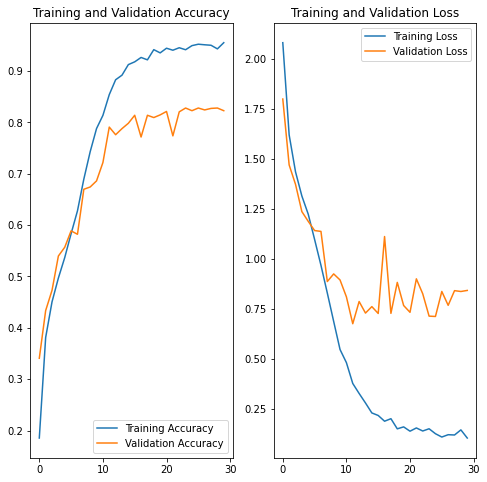

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Still we can see some overfitting in our model**

We did not included normalization in previous model, so will include and verify.

In [ ]:
model_normalized = Sequential()
model_normalized.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# model_normalized.add(data_augmentation)
model_normalized.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model_normalized.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model_normalized.add(MaxPooling2D(pool_size = (2, 2)))
# model_normalized.add(Dropout(0.1))

model_normalized.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_normalized.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized.add(MaxPooling2D(pool_size=(2, 2)))
# model_normalized.add(Dropout(0.1))

model_normalized.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model_normalized.add(Conv2D(128, (3, 3), activation='relu'))
model_normalized.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized.add(MaxPooling2D(pool_size=(2, 2)))
# model_normalized.add(Dropout(0.1))


model_normalized.add(Flatten())
model_normalized.add(Dense(128, activation='relu'))
# model_normalized.add(Dropout(0.2))
model_normalized.add(Dense(256, activation='relu'))
# model_normalized.add(Dropout(0.2))
# model_normalized.add(Dense(256, activation='relu'))
# model_normalized.add(Dropout(0.2))
model_normalized.add(Dense(len(class_names), activation='softmax'))

model_normalized.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adamax',
              metrics=['accuracy'])
model_normalized.summary()
epochs = 30
## Your code goes here, use 30 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history_normalized = model_normalized.fit(train_ds_new,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds_new,
                    )

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_48 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_366 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_367 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_368 (Conv2D)          (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_369 (Conv2D)          (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 43, 43, 64)      

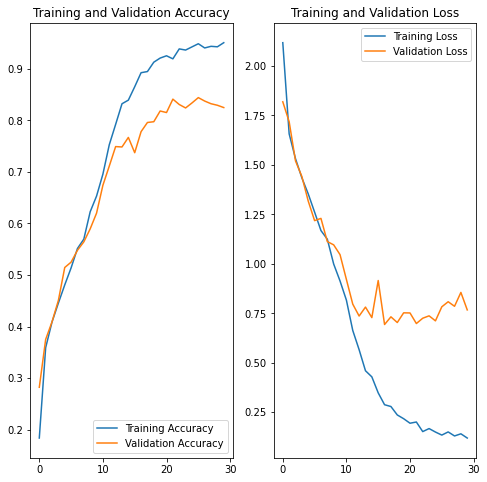

In [ ]:
acc = history_normalized.history['accuracy']
val_acc = history_normalized.history['val_accuracy']

loss = history_normalized.history['loss']
val_loss = history_normalized.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After adding batch normalization fluctuation reduced a little bit next we will use dropout layers for removing overfitting of our model

In [ ]:
model_normalized_drop = Sequential()
model_normalized_drop.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# model_normalized_drop.add(data_augmentation)
model_normalized_drop.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model_normalized_drop.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model_normalized_drop.add(MaxPooling2D(pool_size = (2, 2)))
# model_normalized_drop.add(Dropout(0.1))

model_normalized_drop.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_normalized_drop.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_normalized_drop.add(Dropout(0.2))

model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu'))
model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_normalized_drop.add(Dropout(0.2))


model_normalized_drop.add(Flatten())
model_normalized_drop.add(Dense(128, activation='relu'))
# model_normalized_drop.add(Dropout(0.2))
model_normalized_drop.add(Dense(256, activation='relu'))
model_normalized_drop.add(Dropout(0.4))
# model_normalized_drop.add(Dense(256, activation='relu'))
# model_normalized_drop.add(Dropout(0.2))
model_normalized_drop.add(Dense(len(class_names), activation='softmax'))

model_normalized_drop.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adamax',
              metrics=['accuracy'])
model_normalized_drop.summary()
epochs = 30
## Your code goes here, use 30 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history_normalized_dropout = model_normalized_drop.fit(train_ds_new,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds_new,
                    )

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_49 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_373 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_374 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_375 (Conv2D)          (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_376 (Conv2D)          (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 43, 43, 64)      

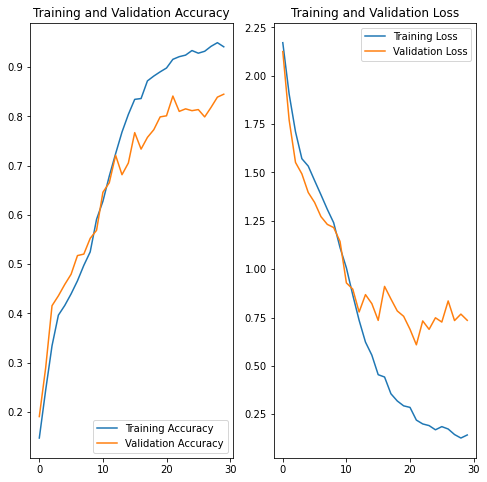

In [ ]:
acc = history_normalized_dropout.history['accuracy']
val_acc = history_normalized_dropout.history['val_accuracy']

loss = history_normalized_dropout.history['loss']
val_loss = history_normalized_dropout.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Overfitting reduced a little bit but still we can improve this, so will increase droput percentage.**

In [ ]:
model_normalized_drop = Sequential()
model_normalized_drop.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# model_normalized_drop.add(data_augmentation)
model_normalized_drop.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model_normalized_drop.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model_normalized_drop.add(MaxPooling2D(pool_size = (2, 2)))
# model_normalized_drop.add(Dropout(0.1))

model_normalized_drop.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_normalized_drop.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_normalized_drop.add(Dropout(0.2))

model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu'))
model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_normalized_drop.add(Dropout(0.3))


model_normalized_drop.add(Flatten())
model_normalized_drop.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_normalized_drop.add(Dropout(0.4))
model_normalized_drop.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model_normalized_drop.add(Dropout(0.5))
# model_normalized_drop.add(Dense(256, activation='relu'))
# model_normalized_drop.add(Dropout(0.2))
model_normalized_drop.add(Dense(len(class_names), activation='softmax'))

model_normalized_drop.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adamax',
              metrics=['accuracy'])
model_normalized_drop.summary()
epochs = 30
## Your code goes here, use 30 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history_normalized_dropout = model_normalized_drop.fit(train_ds_new,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds_new,
                    )

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_50 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_380 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_381 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_382 (Conv2D)          (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_383 (Conv2D)          (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 43, 43, 64)      

**After increasing dropout value our accuracy reduced alot so will add regularization instead**

In [ ]:
model_normalized_drop = Sequential()
model_normalized_drop.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# model_normalized_drop.add(data_augmentation)
model_normalized_drop.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model_normalized_drop.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model_normalized_drop.add(MaxPooling2D(pool_size = (2, 2)))
# model_normalized_drop.add(Dropout(0.1))

model_normalized_drop.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_normalized_drop.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_normalized_drop.add(Dropout(0.2))

model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu'))
model_normalized_drop.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model_normalized_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_normalized_drop.add(Dropout(0.2))


model_normalized_drop.add(Flatten())
model_normalized_drop.add(Dense(128, activation='relu'))
model_normalized_drop.add(Dropout(0.4))
model_normalized_drop.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
# model_normalized_drop.add(Dropout(0.5))
# model_normalized_drop.add(Dense(256, activation='relu'))
# model_normalized_drop.add(Dropout(0.2))
model_normalized_drop.add(Dense(len(class_names), activation='softmax'))

model_normalized_drop.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adamax',
              metrics=['accuracy'])
model_normalized_drop.summary()
epochs = 30
## Your code goes here, use 30 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
history_normalized_dropout = model_normalized_drop.fit(train_ds_new,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds_new,
                    )

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_51 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_387 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_388 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_171 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_389 (Conv2D)          (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_390 (Conv2D)          (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 43, 43, 64)      

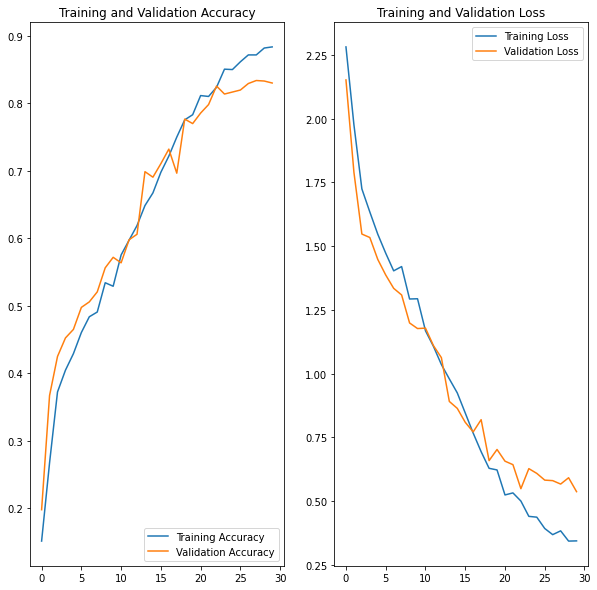

In [ ]:
acc = history_normalized_dropout.history['accuracy']
val_acc = history_normalized_dropout.history['val_accuracy']

loss = history_normalized_dropout.history['loss']
val_loss = history_normalized_dropout.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Q 1:  Did we get rid of the overfitting?

---
After experimenting with different droput values and regularization terms we got a model with decent accuracy for both train and validation data and the overfitting in our model is gone now..



---
*Basic model*

Accuracy: around 60%

Val. Accuracy: around 50%


---
*Basic model + data aug.*

Accuracy: around 57%

Val. Accuracy: around 55%

---
*Basic model + dropouts + rebalancing + batch normalization + regularization*

Accuracy: around 87%

Val. Accuracy: around 83%

Q 2:  Did class rebalancing helped?

---
Yes class rebalancing did helped in increasing accuracy of our model.

---